In [1]:
import random
import scipy
import numpy as np
from numpy import linalg
from scipy.stats import t, f, norm, ksone
import matplotlib.pyplot as plt

In [2]:
n = 50
n_koeffs= 5
p = n_koeffs + 1


Для распределения Кси равномерного(-1,1)

In [3]:
def get_x():
    return [random.uniform(-1, 1) for i in range(n_koeffs)]

Для распределения нормального

In [4]:
def get_y(x):
    return random.normalvariate(2 + 3*x[0,0] - 2*x[0,1] + x[0,2] + x[0,3] - x[0,4], 1.5)

In [5]:
X = [];
for i in range(n):
    X.append(get_x())
X = np.matrix(X);
Y = np.matrix([get_y(X[i]) for i in range(n)]).T


## а) Проверить на мультиколлинеарность(Наличие линейной зависимости между объясняющими переменными (факторами) регрессионной модели.)

In [6]:
def psi_point(x):
    return np.matrix([1] + x)
def get_Psi(X):
     return np.append(np.matrix(np.ones(X.shape[0])).T, X.copy(), 1)
def get_F(Psi):
    return Psi.T @ Psi;
def get_beta(Psi, Y):
    return get_inv(get_F(Psi)) @ Psi.T @ Y
def get_e(Y, Psi, beta):
    return Y - Psi @ beta
def get_inv(A):
    return linalg.inv(A)
def get_RSS(e):
    return (e.transpose() @ e)[0,0]
def get_TSS(Y):
    av_y = np.sum(Y)/Y.size
    return sum([(Y[i, 0]-av_y)**2 for i in range(Y.size)])
def get_R(RSS, TSS):
    return (TSS - RSS)/TSS
    return sum([(Y[i, 0]-av_y)**2 for i in range(Y.size)])
flag = False
for i in range(n_koeffs):
    Psi = X.copy()
    Psi[:, i] = np.matrix(np.ones(n)).T
    Yi = X[:, i]
    beta = get_beta(Psi, Yi)
    RSS = get_RSS(get_e(Yi, Psi, beta))
    TSS = get_TSS(Yi)
    R = get_R(RSS, TSS)
    if(R>=0.8):
        flag=1
    print(f"R{i} = {R}")

if(not flag):
    print("есть ")
else:
    print("нет")
    
    

R0 = 0.03068475460644355
R1 = 0.04062250707691368
R2 = 0.01619875295925501
R3 = 0.012026252809220353
R4 = 0.01646652446411689
есть 


## b) Определелить уравнение линейной регрессии и значимость коэффициентов

In [7]:
def check_significance_beta(Psi, beta, RSS, n, p, i):
    alpha = 0.05
    delta = beta[i]*(n-p)**0.5
    delta /= (RSS * get_inv(get_F(Psi))[i,i])**0.5
    delta = delta[0,0]
    p_value = 2.*(1-t.cdf(abs(delta), n-p))
    if(p_value < alpha):
        print(f"p_value ({p_value}) < alpha ({alpha}) => beta{i+1} значим")
    else:
        print(f"p_value ({p_value}) > alpha ({alpha}) => beta{i+1} не является значимым")


In [8]:
Psi = get_Psi(X)
beta= get_beta(Psi, Y)
e = get_e(Y, Psi, beta)
RSS = get_RSS(e)
for i in range(p):
    check_significance_beta(Psi, beta, RSS, n, p, i)

p_value (7.327471962526033e-15) < alpha (0.05) => beta1 значим
p_value (1.0058620603103918e-12) < alpha (0.05) => beta2 значим
p_value (4.169684397758999e-08) < alpha (0.05) => beta3 значим
p_value (0.0018418622138778318) < alpha (0.05) => beta4 значим
p_value (0.00027643082843353817) < alpha (0.05) => beta5 значим
p_value (0.00012024848171465763) < alpha (0.05) => beta6 значим


## c) Коэффициент детерминации и проверить его значимость

In [9]:
def check_significance_R(R, n, p):
    alpha = 0.05
    delta = R/(1-R)*(n-p)*1./(p-1)
    p_value = 1-f.cdf(delta, p-1, n-p)
    if(p_value < alpha):
        print(f"p_value ({p_value}) < α ({alpha}) -> регрессия значима")
    else:
        print(f"p_value ({p_value}) > α ({alpha}) -> регрессия не является значимой")
TSS = get_TSS(Y)
R = get_R(RSS, TSS)
print(f"TSS = {TSS}")
print(f"R^2 = {R}")
check_significance_R(R, n, p)

TSS = 413.65466794907644
R^2 = 0.7901426453344577
p_value (7.283063041541027e-14) < α (0.05) -> регрессия значима


## d) Найти значение в точке x_k=0 и постороить 95% доверительный интервал

In [10]:
def get_forecast(x0, beta):
    Psi_0 = psi_point(x0)
    return (Psi_0 @ beta)[0,0]

def forecast(x0, beta, F, RSS, n, p, gamma):
    Psi_0 = psi_point(x0)
    y0 = get_forecast(x0, beta)
    print(f"Прогноз в точке x_k: {y0}")
    
    t_gamma = t.ppf((1+gamma)/2, n-p)
    F_1 = get_inv(get_F(Psi))
    delta = t_gamma * (1 + (Psi_0*F_1*Psi_0.T)[0,0])**0.5 * (RSS/(n-p))**0.5
    print(f"Доверительный интервал: ({y0-delta}, {y0+delta})")

In [11]:
F = get_F(Psi)
forecast([0 for i in range(n_koeffs)], beta, F, RSS, n, p, 0.95)

Прогноз в точке x_k: 2.340374751328718
Доверительный интервал: (-0.5199484727938422, 5.200697975451279)


## е) Проверим предположении о независимости ошибок измерения

In [27]:
def check_error_independence(e):
    alpha = 0.05
    n = e.size
    I = 0
    for i in range(n):
        for j in range(i+1, n):
            if e[i, 0] > e[j, 0]:
                I += 1
    print(f"I = {I}")
    
    delta = (I - n*(n-1)/4) / np.sqrt(n**3 / 36) 
    print(f"delta = {delta}")
    
    p_value = 2.*(1-norm.cdf(abs(delta)))
    print(f"p_value = {p_value}")
    if(p_value < alpha):
        print(f"p_value < α -> ошибки зависимы")
    else:
        print(f"p_value > α -> ошибки независимы")

In [28]:
check_error_independence(e)

I = 606
delta = -0.11030865786510141
p_value = 0.9121645911853389
p_value > α -> ошибки независимы


## f) Проверим предположение о нормальном распределении ошибок

In [29]:
def get_av_e(e):
    return sum(e)/n

def get_sigma_for_err_norm(e):
    n = e.size
    av_e = get_av_e(e)
    sigma = sum([(e[i, 0] - av_e)**2 for i in range(n)])/(n-1)
    return np.sqrt(sigma[0,0])
    
    
def get_delta_for_err_norm(e):
    n = e.size
    F = lambda x: (e < x).sum()/n
    sigma = get_sigma_for_err_norm(e)
    av_e = get_av_e(e)
    F_n = lambda x: norm.cdf(x, av_e, sigma)
    F = np.matrix([F(e[i, 0]) for i in range(n)]).T
    F_n = F_n(e)
    delta = np.max(np.abs(F - F_n))*np.sqrt(n)
    return delta

def check_error_norm(e):
    n = e.size
    sigma = get_sigma_for_err_norm(e)
    print(f"sigma = {sigma}")
    delta = get_delta_for_err_norm(e)
    print(f"delta = {delta}")
    delta_i = []
    N = 10000
    av_e = get_av_e(e)
    for i in range(N):
        e_i = np.matrix([norm.rvs(av_e, sigma) for i in range(n)]).T
        delta_i.append(get_delta_for_err_norm(e_i))
    k = (delta_i < delta).sum() + 1
    p_value = 1-(k-1)/N
    print(f"p_value = {p_value}")
    
def draw_F(e):
    x = np.linspace(np.min(e)-1, np.max(e)+1, 1000)
    n = e.size
    F = lambda x: (e < x).sum()/n
    sigma = get_sigma_for_err_norm(e)
    F_n = lambda x: norm.cdf(x, 0, sigma)
    plt.plot(x, [F(x[i]) for i in range(x.size)])
    plt.plot(x, F_n(x))

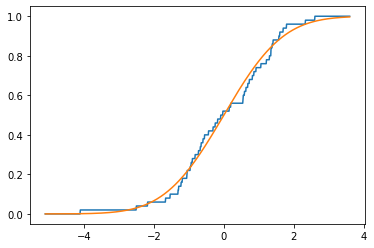

In [30]:
get_sigma_for_err_norm(e)
draw_F(e)
# check_error_norm(e)

In [31]:
check_error_norm(e)

sigma = 1.3310152206373511
delta = 0.6954492792029607
p_value = 0.1654


## h) Кросс-проверка регрессии на выбросы

In [40]:
def get_Rcv(CVSS, TSS):
    return (TSS - CVSS)/TSS

def CV(X, Y):
    CVSS = 0
    for i in range(X.shape[0]):
        x = [X[i,j].copy() for j in range(X.shape[1])]
        y = Y[i].copy()
        X_i = np.delete(X, i, 0)
        Y_i = np.delete(Y, i, 0)
        Psi_i = get_Psi(X_i)
        beta_i = get_beta(Psi_i, Y_i)
        CVSS += ((get_forecast(x, beta_i) - y) ** 2)[0,0]
    print(f"CVSS = {CVSS}")
    TSS = get_TSS(Y)
    print(f"Rcv = {get_Rcv(CVSS, TSS)}")


In [41]:
CV(X, Y)

CVSS = 112.9210061382589
Rcv = 0.7270162411121147


## i) пять измерений в одной точке

In [51]:
def get_sigma_for_y(y):
    l = y.size
    av_y = sum(y)/l
    sigma = sum([(y[i] - av_y)**2 for i in range(l)])/(l-1)
    return sigma

def check_adequacy(RSS, n, p):
    alpha = 0.05
    k = 5
    x = np.matrix(get_x())
    y_x = np.array([get_y(x) for i in range(k)])
    print("x = " + ", ".join(map(str, x[0].tolist())))
    for i in range(len(y_x)):
        print(f"y{i+1} = {y_x[i]}")
        
    sigma = get_sigma_for_y(y_x)
    print(f"sigma^2 = {sigma}")
    
    if(RSS <= sigma*(k-1)):
        print(f"{RSS} <= {sigma*(k-1)} -> Модель адекватна без проверки")
        return
    
    print(f"\n{RSS} > {sigma*(k-1)} -> нужна проверка")
    delta = RSS/(n-p)/sigma
    print(f"delta = {delta}")
    
    p_value = 1-f.cdf(delta, n-p, k-1)
    print(f"p_value = {p_value}")
    if(p_value < alpha):
        print(f"p_value < alpha -> Модель не адекватна")
    else:
        print(f"p_value > alpha -> Модель адекватна")

In [52]:
check_adequacy(RSS, n, p)

x = [-0.6171695903825214, -0.11171552103764815, -0.7271247468881701, -0.2367307305513373, 0.9236272448138096]
y1 = -0.36980777437381485
y2 = -2.11311553192252
y3 = 0.636483991302428
y4 = -0.9804599853611029
y5 = -3.8351024203348167
sigma^2 = 2.9499964711203

86.80847436084652 > 11.7999858844812 -> нужна проверка
delta = 0.668787197256605
p_value = 0.779972936672003
p_value > alpha -> Модель адекватна


## j) Удалить наименее значимый коэффициент и повторить b и с!

In [58]:
num_del = 3
Psi = get_Psi(X)
Psi1 = np.delete(Psi, num_del, 1)
p1 = p-1
beta1 = get_beta(Psi1, Y)
e1 = get_e(Y, Psi1, beta1)
RSS1 = get_RSS(e1)
print(f"RSS = {RSS1}")
for i in range(p1):
    check_significance_beta(Psi1, beta1, RSS1, n, p1, i)

RSS = 108.48904721186378
p_value (1.3988810110276972e-13) < alpha (0.05) => beta1 значим
p_value (2.262190434976219e-11) < alpha (0.05) => beta2 значим
p_value (7.381328992472902e-07) < alpha (0.05) => beta3 значим
p_value (0.0003707154086511899) < alpha (0.05) => beta4 значим
p_value (0.0005659339191019797) < alpha (0.05) => beta5 значим


## k)Bootstrap

In [65]:
def get_X_1(X):
    X_1 = []
    for j in range(X.shape[0]):
        X_1.append(random.choices(X[j].tolist()[0], k=X.shape[1]))
    return np.matrix(X_1)

def get_R_for_Psi(Psi_1, Y):
    beta_1 = get_beta(Psi_1, Y)
    e_1 = get_e(Y, Psi_1, beta_1)
    RSS_1 = get_RSS(e_1)
    TSS = get_TSS(Y)
    R_1 = get_R(RSS_1, TSS)
    return R_1

def comp_bootstrap(X, Y, num_del):
    alpha = 0.05
    N = 1000
    n = X.shape[0]
    
    Psi = get_Psi(X)
    Psi1 = np.delete(Psi, num_del, 1)
    delta = get_R_for_Psi(Psi, Y) - get_R_for_Psi(Psi1, Y)
    
    delta_1 = []
    for i in range(N):
        X_1 = get_X_1(X)
        Psi_1 = get_Psi(X_1)
        Psi1_1 = np.delete(Psi_1, num_del, 1)
        delta_1.append(get_R_for_Psi(Psi_1, Y) - get_R_for_Psi(Psi1_1, Y))
    
    m = (delta_1 >= delta).sum()
    p_value = m/N
    print(f"p_value = {p_value}")
    if(p_value < alpha):
        print(f"p_value < alpha => Усложнение оправдано")
    else:
        print(f"p_value > alpha => Усложнение не оправдано")

In [66]:
comp_bootstrap(X, Y, num_del)

p_value = 0.149
p_value > alpha => Усложнение не оправдано
